In [62]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import sys
import os
import gc
import copy
from collections import defaultdict
import itertools
import plotly as ply
ply.io.renderers.default="notebook"
import ipywidgets as widgets
from ipywidgets import interact
import sklearn as skl
from sklearn.neighbors import KernelDensity

In [38]:
!ls */*
#!head dataFiles/neg200mV_cAMP_z.csv

dataFiles/Bootstrapping_PMF_Data.csv dataFiles/PMF_Analysis_Summary.csv
dataFiles/Ion_Coordinate_Data.csv    dataFiles/neg200mV_cAMP_z.csv
dataFiles/Ion_PMF_Data.csv           dataFiles/pos200mV_cAMP_z.csv


In [45]:
dataDir="dataFiles"
print(dataDir)
nV_file='/'.join([dataDir,"neg200mV_cAMP_z.csv"])
print(nV_file)
nV_data=pd.read_csv(nV_file)
nV_data.head()

dataFiles
dataFiles/neg200mV_cAMP_z.csv


Unnamed: 0       1357       1358       1359       1360       1361  \
0           0 -25.384398 -30.174370 -29.176856  36.757571 -65.633329   
1           1 -35.275240 -31.261016 -36.371425 -22.444063  35.558173   
2           2 -34.716077 -30.011503 -36.765131 -23.000502  34.609343   
3           3 -34.169736 -31.458524 -34.907743 -24.550263  36.099138   
4           4 -31.770490 -30.296522 -33.472426 -23.356207  36.592455   

        1362       1363       1364       1365  ...       1374       1375  \
0 -70.280236  39.926082 -45.848485 -51.379589  ...  51.995079 -26.230838   
1 -15.619842 -30.105586 -25.154636 -21.883440  ...  33.409478 -14.575104   
2 -13.823077 -29.252614 -25.122128 -21.844900  ...  32.986014 -14.714094   
3 -15.355771 -29.237919 -26.675277 -21.629661  ...  31.424729 -14.223112   
4 -16.079024 -26.857642 -26.294826 -21.375335  ...  33.844680 -14.305354   

        1376       1377       1378       1379       1380       1381  \
0  39.347927  44.342980  36.374933  68.946688 -27.552525 -30.300643   
1 -29.320288  42.395383 -20.408563 -31.503243 -28.711897 -63.268397   
2 -31.331820  44.706944 -20.930103 -29.596450 -24.472217 -63.313351   
3 -29.697153  39.043511 -20.338687 -31.490100 -29.381575 -65.722318   
4 -32.944454  28.183213 -22.105757 -29.641047 -29.303860 -56.396434   

        1382       1383  
0  -7.330339  56.264536  
1 -18.574502 -29.165463  
2 -18.171909 -28.100961  
3 -18.138909 -28.522883  
4 -17.731128 -28.278403  

[5 rows x 28 columns]

In [46]:
print("1", nV_data.columns)
nV_data=nV_data.rename(columns={colName:'frame' for colName in nV_data.columns \
                               if 'Unnamed' in colName})
print("2", nV_data.columns)

1 Index(['Unnamed: 0', '1357', '1358', '1359', '1360', '1361', '1362', '1363',
       '1364', '1365', '1366', '1367', '1368', '1369', '1370', '1371', '1372',
       '1373', '1374', '1375', '1376', '1377', '1378', '1379', '1380', '1381',
       '1382', '1383'],
      dtype='object')
2 Index(['frame', '1357', '1358', '1359', '1360', '1361', '1362', '1363', '1364',
       '1365', '1366', '1367', '1368', '1369', '1370', '1371', '1372', '1373',
       '1374', '1375', '1376', '1377', '1378', '1379', '1380', '1381', '1382',
       '1383'],
      dtype='object')


In [47]:
nV_data=nV_data.melt(id_vars='frame',var_name='ion_index',value_name='z')
print("~~~~~~~")
nV_data.head()

~~~~~~~


frame ion_index          z
0      0      1357 -25.384398
1      1      1357 -35.275240
2      2      1357 -34.716077
3      3      1357 -34.169736
4      4      1357 -31.770490

In [57]:
nV_data['voltage']=-200
nV_data=nV_data[['voltage', 'frame', 'ion_index', 'z']]
display(nV_data.head())
nV_data.describe()

voltage  frame ion_index          z
0     -200      0      1357 -25.384398
1     -200      1      1357 -35.275240
2     -200      2      1357 -34.716077
3     -200      3      1357 -34.169736
4     -200      4      1357 -31.770490

voltage          frame              z
count  267813.0  267813.000000  267813.000000
mean     -200.0    4959.000000     -16.372790
std         0.0    2863.373991      29.927054
min      -200.0       0.000000     -84.336787
25%      -200.0    2479.000000     -28.726879
50%      -200.0    4959.000000     -23.046127
75%      -200.0    7439.000000     -16.131300
max      -200.0    9918.000000      83.019765

In [56]:
pV_file='/'.join([dataDir,"pos200mV_cAMP_z.csv"])
pV_data=pd.read_csv(pV_file)
pV_data=pV_data.rename(columns={colName:'frame' for colName in pV_data.columns \
                               if 'Unnamed' in colName})
pV_data=pV_data.melt(id_vars='frame',var_name='ion_index',value_name='z')
pV_data['voltage']=200
pV_data=pV_data[['voltage','frame','ion_index','z']]
pV_data.head()
pV_data.describe()

voltage          frame              z
count  267813.0  267813.000000  267813.000000
mean      200.0    4959.000000     -13.860706
std         0.0    2863.373991      32.406261
min       200.0       0.000000     -84.834234
25%       200.0    2479.000000     -28.993487
50%       200.0    4959.000000     -22.793476
75%       200.0    7439.000000     -15.217315
max       200.0    9918.000000      82.769893

In [92]:
ionData=pd.concat([pV_data,nV_data])
ionData.head(n=10)


voltage  frame ion_index          z
0      200      0      1357 -25.384398
1      200      1      1357 -34.099881
2      200      2      1357 -41.649691
3      200      3      1357 -40.350572
4      200      4      1357 -39.439099
5      200      5      1357 -40.578023
6      200      6      1357 -39.800972
7      200      7      1357 -33.918705
8      200      8      1357 -35.660695
9      200      9      1357 -34.075938

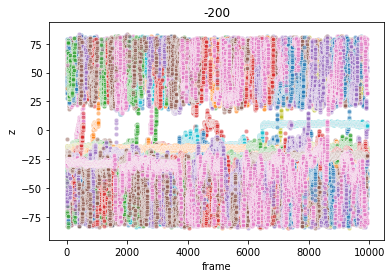

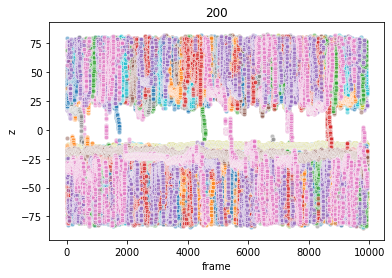

In [109]:
for volName,volData in ionData.groupby('voltage'):
    #plt.figure(figsize=(5,4))
    for iName, iData in tqdm.tqdm_notebook(volData.groupby('ion_index')):
        sns.scatterplot(x='frame',y='z',data=iData, s=20,alpha=0.5,legend=False)
    plt.title(volName)
    plt.show()

In [110]:
zbin=np.arange(ionData.z.min(),ionData.z.max(),2)
print(zbin)

[-84.83423446 -82.83423446 -80.83423446 -78.83423446 -76.83423446
 -74.83423446 -72.83423446 -70.83423446 -68.83423446 -66.83423446
 -64.83423446 -62.83423446 -60.83423446 -58.83423446 -56.83423446
 -54.83423446 -52.83423446 -50.83423446 -48.83423446 -46.83423446
 -44.83423446 -42.83423446 -40.83423446 -38.83423446 -36.83423446
 -34.83423446 -32.83423446 -30.83423446 -28.83423446 -26.83423446
 -24.83423446 -22.83423446 -20.83423446 -18.83423446 -16.83423446
 -14.83423446 -12.83423446 -10.83423446  -8.83423446  -6.83423446
  -4.83423446  -2.83423446  -0.83423446   1.16576554   3.16576554
   5.16576554   7.16576554   9.16576554  11.16576554  13.16576554
  15.16576554  17.16576554  19.16576554  21.16576554  23.16576554
  25.16576554  27.16576554  29.16576554  31.16576554  33.16576554
  35.16576554  37.16576554  39.16576554  41.16576554  43.16576554
  45.16576554  47.16576554  49.16576554  51.16576554  53.16576554
  55.16576554  57.16576554  59.16576554  61.16576554  63.16576554
  65.16576

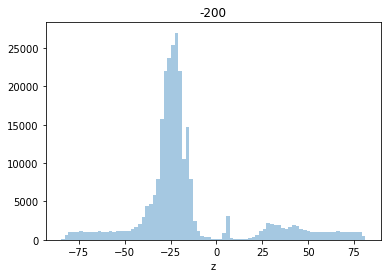

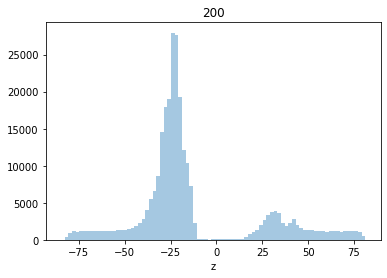

In [127]:
for volName,volData in ionData.groupby('voltage'):
    sns.distplot(volData.z,bins=zbin,kde=False)
    plt.title(volName)
    plt.show()
    
  

[-75. -73. -71. -69. -67. -65. -63. -61. -59. -57. -55. -53. -51. -49.
 -47. -45. -43. -41. -39. -37. -35. -33. -31. -29. -27. -25. -23. -21.
 -19. -17. -15. -13. -11.  -9.  -7.  -5.  -3.  -1.   1.   3.   5.   7.
   9.  11.  13.  15.  17.  19.  21.  23.  25.  27.  29.  31.  33.  35.
  37.  39.  41.  43.  45.  47.  49.  51.  53.  55.  57.  59.  61.  63.
  65.  67.  69.  71.  73.  75.]
[-74. -72. -70. -68. -66. -64. -62. -60. -58. -56. -54. -52. -50. -48.
 -46. -44. -42. -40. -38. -36. -34. -32. -30. -28. -26. -24. -22. -20.
 -18. -16. -14. -12. -10.  -8.  -6.  -4.  -2.   0.   2.   4.   6.   8.
  10.  12.  14.  16.  18.  20.  22.  24.  26.  28.  30.  32.  34.  36.
  38.  40.  42.  44.  46.  48.  50.  52.  54.  56.  58.  60.  62.  64.
  66.  68.  70.  72.  74.]


voltage     z   density       PMF
0     -200 -74.0  0.004117  1.991447
1     -200 -72.0  0.003991  2.010627
2     -200 -70.0  0.003724  2.053403
3     -200 -68.0  0.004121  1.990875
4     -200 -66.0  0.004045  2.002417

voltage     z   density       PMF
0     -200 -74.0  0.004117  1.991447
1     -200 -72.0  0.003991  2.010627
2     -200 -70.0  0.003724  2.053403
3     -200 -68.0  0.004121  1.990875
4     -200 -66.0  0.004045  2.002417

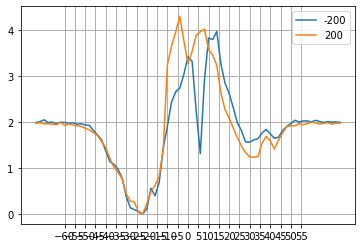

In [172]:
binWidth=2.0
zMin=-75
zMax=75
zBins=np.arange(zMin,zMax+binWidth,binWidth)
print(zBins)
zMids=(zBins[1:]+zBins[:-1])/2.
print(zMids)
kb=0.0019872041
T=310.15
kbT=kb*T

pmfFrames=[]
for volName, volData in ionData.groupby('voltage'):
    histData=np.histogram(volData.z,zBins)
    histDens=histData[0]/np.sum(histData[0])
    histPMF=-kbT*np.log(histDens)
    histPMF=histPMF-np.min(histPMF)
    sns.lineplot(zMids, histPMF,label=volName)
    pmfFrames.append(pd.DataFrame({'voltage':[volName]*len(zMids),
                                  'z':zMids,
                                  'density':histDens,
                                  'PMF':histPMF}).copy())
    plt.xticks(np.arange(-60,60,5))
    plt.grid( linestyle='-', linewidth=1)
    pmfData=pd.concat(pmfFrames)
    display(pmfData.head())

# #Perform bootstrap for PMF

In [ ]:
nBootSamples=1000
bandwidth=binWidth
bootFrames=[]
for volName,volData in ionData.groupby('voltage'):
    for iBoot in tqdm.tqdm_notebook(
         np.arange(nBootSamples),desc='Bootstrapping %f V data'%volName):
         boothist=np.histogram(volData.z.sample(frac=1.0,replace=True),zBins)
         bootdens=boothist[0]/np.sum(boothist[0])
         bootPMF=-kbT*np.log(bootdens)
         bootPMF=bootPMF-np.min(bootPMF)
         bootFrames.append(pd.DataFrame({'voltage':[volName]*len(zMids),
                                         'bootsampe_index':[iBoot]*len(zMids),
                                  'z':zMids,
                                  'density':bootdens,
                                  'PMF':bootPMF}).copy())
         
         bootData=pd.concat(bootFrames)
         display(bootData.head())
        

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174

voltage  bootsampe_index     z   density       PMF
0     -200                0 -74.0  0.004305  1.967048
1     -200                0 -72.0  0.004068  2.001955
2     -200                0 -70.0  0.003865  2.033446
3     -200                0 -68.0  0.004140  1.991046
4     -200                0 -66.0  0.003911  2.026174